# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
%load_ext autoreload
%autoreload 2

from maddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import torch
import pickle

from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:\n', states[0])
print('The state for the second agent looks like:\n', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like:
 [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]
The state for the second agent looks like:
 [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.4669857  -1.5         0.          0.
 -6.83172083  6.          0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

## DDPG Loop

In [7]:
def ddpg(n_episodes=2000, window_size=100, win_criteria=0.5, print_every=10, save_every=100,
         test_run = False, saved_state_paths = None):

    if saved_state_paths is not None:                             # loading back intermediate results:
        with open(saved_state_paths[0], 'rb') as f:               # first object in tuple is the scores and deque pickle
            scores_deque, scores = pickle.load(f)
        agent0.actor_local.load_state_dict(torch.load(saved_state_paths[1]))   # next object is the actor network
        agent0.critic_local.load_state_dict(torch.load(saved_state_paths[2]))  # last object is the critic network
        agent1.actor_local.load_state_dict(torch.load(saved_state_paths[3]))   # next object is the actor network
        agent1.critic_local.load_state_dict(torch.load(saved_state_paths[4]))  # last object is the critic network

        start_episode = len(scores)+1
        
        best_score = max(scores)
        best_episode = scores.index(max(scores))

    else:                                                   # starting from scratch
        scores_deque = deque(maxlen=window_size) 
        scores = []
        start_episode = 1
        
        best_score = float("-inf")
        best_episode = -1
            
    for i_episode in range(start_episode, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations.reshape((1,48))
        
        # reset agents and scores
        agent0.reset()
        agent1.reset()
        episode_scores = np.zeros(num_agents) 
        
        if not test_run:                          # if we're testing, don't actually run the episodes

            stepNum = 0
            while True:
            
                add_noise = True
                actions = np.concatenate((agent0.act(states,add_noise), agent1.act(states,add_noise)), axis = 0).flatten()
                env_info = env.step(actions)[brain_name]
                next_states = env_info.vector_observations.reshape((1,48))
                
                rewards = env_info.rewards
                dones = env_info.local_done

                # TODO - move agent numbers to local variables
                agent0.step(states, actions, rewards[0], next_states, dones, 0)
                agent1.step(states, actions, rewards[1], next_states, dones, 1)
        
#                 print('\rActions {:.2f} {:.2f} {:.2f} {:.2f}'.format(actions[0],actions[1],actions[2],actions[3]),end="\r")
                
                # Learn, if enough samples are available in memory and at learning interval settings
                if len(buff.memory) > buff.batch_size and stepNum % h.LEARN_EVERY == 0:
                    stepNum += 1
                    for _ in range(h.LEARN_NUM):
                        experiences = buff.sample()
                        agent0.learn(experiences, h.GAMMA, 0)
                        agent1.learn(experiences, h.GAMMA, 1)

                episode_scores += np.max(rewards)
                states = next_states
        
                # end if any are done
                if np.any(dones):
                    break

        episode_score = np.max(episode_scores)  # episode score(s)
        scores_deque.append(episode_score)      # append scores to deque
        scores.append(episode_score)            # append scores to overall array
        average_score = np.mean(scores_deque)   # get the average inside the moving window

        if episode_score > best_score:
            best_score = episode_score
            best_episode = i_episode
            if episode_score > 0:
                print('\n>>>>>> New best score {:.2f} at episode {}'.format(best_score, best_episode))
        
        print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f} ({:.2f}/{:.2f})'.format(i_episode, average_score, episode_score, episode_scores[0], episode_scores[1]), end="")
        if i_episode % print_every == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score))

        if i_episode % save_every == 0:
            # Saving the objects:
            episode_string = str(i_episode)
#             print('saving checkpoint')
            with open('cp_save_state_'+episode_string+'.pkl', 'wb') as f:
                pickle.dump([scores_deque, scores], f)
            torch.save(agent0.actor_local.state_dict(), 'cp_actor0_'+episode_string+'.pth')
            torch.save(agent0.critic_local.state_dict(), 'cp_critic0_'+episode_string+'.pth')
            torch.save(agent1.actor_local.state_dict(), 'cp_actor1_'+episode_string+'.pth')
            torch.save(agent1.critic_local.state_dict(), 'cp_critic1_'+episode_string+'.pth')

            
        if average_score >= win_criteria:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode, average_score))
            episode_string = str(i_episode)
            with open('cp_save_state_'+episode_string+'.pkl', 'wb') as f:
                pickle.dump([scores_deque, scores], f)
            torch.save(agent0.actor_local.state_dict(), 'cp_actor0_solved.pth')
            torch.save(agent0.critic_local.state_dict(), 'cp_critic0_solved.pth')
            torch.save(agent1.actor_local.state_dict(), 'cp_actor1_solved.pth')
            torch.save(agent1.critic_local.state_dict(), 'cp_critic1_solved.pth')

            break

    np.save('cp_scores.npy', scores)
    return scores


In [8]:
from ReplayBuffer import ReplayBuffer
import hyperparameters as h

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

buff = ReplayBuffer(action_size, h.BUFFER_SIZE, h.BATCH_SIZE, h.SEED, device)

agent0 = Agent(state_size=state_size, action_size=action_size, random_seed=h.SEED, num_agents=1, replay_buffer = buff, device = device)
agent1 = Agent(state_size=state_size, action_size=action_size, random_seed=h.SEED, num_agents=1, replay_buffer = buff, device = device)

# lastSavedEpisode = str(800)
# saved_state_paths = ['cp_save_state_'+lastSavedEpisode+'.pkl',
#                      'cp_actor0_'+lastSavedEpisode+'.pth',
#                      'cp_critic0_'+lastSavedEpisode+'.pth',
#                      'cp_actor1_'+lastSavedEpisode+'.pth',
#                      'cp_critic1_'+lastSavedEpisode+'.pth']

saved_state_paths = None

test_scores = ddpg(n_episodes=1000,print_every=100, save_every=100, test_run=False, saved_state_paths=saved_state_paths)


Episode: 3	Average Score: 0.00	Current Score: 0.00 (0.00/0.00)
>>>>>> New best score 0.10 at episode 4
Episode: 81	Average Score: 0.01	Current Score: 0.00 (0.00/0.00)
>>>>>> New best score 0.30 at episode 82
Episode: 100	Average Score: 0.01	Current Score: 0.00 (0.00/0.00)
Episode: 200	Average Score: 0.01	Current Score: 0.10 (0.10/0.10)
Episode: 300	Average Score: 0.02	Current Score: 0.00 (0.00/0.00)
Episode: 400	Average Score: 0.02	Current Score: 0.00 (0.00/0.00)
Episode: 500	Average Score: 0.01	Current Score: 0.00 (0.00/0.00)
Episode: 600	Average Score: 0.02	Current Score: 0.00 (0.00/0.00)
Episode: 700	Average Score: 0.01	Current Score: 0.00 (0.00/0.00)
Episode: 800	Average Score: 0.02	Current Score: 0.00 (0.00/0.00)
Episode: 900	Average Score: 0.01	Current Score: 0.00 (0.00/0.00)
Episode: 1000	Average Score: 0.01	Current Score: 0.10 (0.10/0.10)


33832


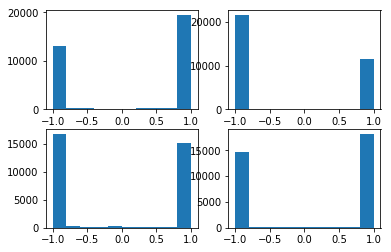

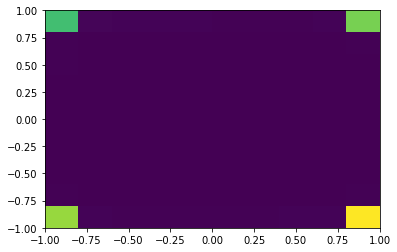

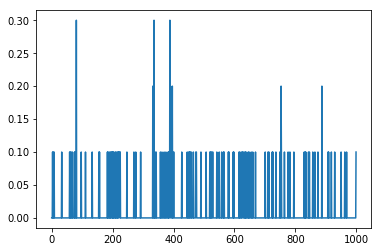

In [9]:
actionMat = np.zeros((len(buff.memory),4))
for i in range(len(buff.memory)):
    actionMat[i,:] = buff.memory[i].action
print(len(buff.memory))
plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(actionMat[:,i])
    
plt.figure()
plt.hist2d(actionMat[:,[0,2]].flatten(),actionMat[:,[1,3]].flatten())

plt.figure()
plt.plot(test_scores)
plt.show()